# 1. Análise de Sentimentos com B2W Reviews



Este projeto tem como objetivo construir um modelo de Machine Learning capaz de
classificar automaticamente o sentimento de avaliações de clientes em **Positivo** ou **Negativo**.

O modelo será integrado a uma API REST, permitindo que sistemas de atendimento
ao cliente e marketing analisem grandes volumes de feedbacks de forma automática.

Dataset utilizado: **B2W Reviews**, contendo avaliações reais de e-commerce
em português. https://opencor.gitlab.io/corpora/real19b2wreviews01/

## 2. Carregamento dos Dados

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("B2W-Reviews01.csv", low_memory=False)




Nesta etapa:

 - Carrega as bibliotecas e ler o dataset.

## 3. Carregamento e Inspeção Inicial dos Dados


In [6]:
df.shape


(14266, 14)

In [7]:
df.head()


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4.0,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4.0,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4.0,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4.0,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5.0,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14266 entries, 0 to 14265
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   submission_date        14266 non-null  object 
 1   reviewer_id            14266 non-null  object 
 2   product_id             14266 non-null  int64  
 3   product_name           14265 non-null  object 
 4   product_brand          5501 non-null   object 
 5   site_category_lv1      14266 non-null  object 
 6   site_category_lv2      13932 non-null  object 
 7   review_title           14232 non-null  object 
 8   overall_rating         14265 non-null  float64
 9   recommend_to_a_friend  14265 non-null  object 
 10  review_text            13883 non-null  object 
 11  reviewer_birth_year    13619 non-null  float64
 12  reviewer_gender        13859 non-null  object 
 13  reviewer_state         13876 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.5+

O dataset possui mais de 130 mil avaliações e 14 colunas.
Para este projeto, nem todas as colunas serão utilizadas.

As colunas mais importantes são:
- review_text → texto da avaliação
- overall_rating → nota de 1 a 5


## 4. Seleção e Limpeza dos Dados

In [9]:


df = df[['review_text', 'overall_rating']]



In [10]:

df.columns = ['texto', 'nota']


In [11]:

df.dropna(inplace=True)


Nesta etapa:
- Mantivemos apenas texto e nota
- Removemos os registros incompletos
Isso simplifica o problema e evita ruído no modelo.


## 5. Criação do Rótulo de Sentimento

In [12]:
df = df[df['nota'] != 3]


In [13]:
df['sentimento'] = df['nota'].apply(
    lambda x: 'Positivo' if x >= 4 else 'Negativo'
)


In [14]:
df['sentimento'].value_counts()


,count
sentimento,
Positivo,8722
Negativo,3429


Optamos por uma classificação binária (Positivo / Negativo),
conforme recomendado na literatura e no escopo do hackathon.


## 6. Análise Exploratória (EDA)

In [15]:
import matplotlib.pyplot as plt


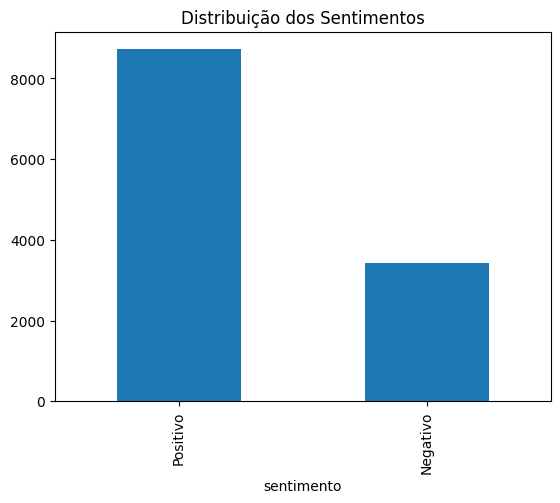

In [16]:
df['sentimento'].value_counts().plot(kind='bar')
plt.title("Distribuição dos Sentimentos")
plt.show()


Dataset levemente desbalanceado

Ainda aceitável para Logistic Regression

Poderia ser balanceado no futuro (SMOTE, class_weight)

## 7. Pré-processamento de Texto

In [17]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_pt = stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zà-ú\s]', '', texto)
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords_pt]
    return ' '.join(palavras)

df['texto_processado'] = df['texto'].apply(limpar_texto)

In [19]:
import unicodedata

def remover_pontuacao(texto):
    return unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')

def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'r\$\s*\d+[\.,]?\d*', '', texto)
    texto = remover_pontuacao(texto)
    texto = re.sub(r'[^a-z\s]', '', texto)
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stopwords_pt]
    return ' '.join(palavras)

df['texto_processado'] = df['texto'].apply(limpar_texto)

A função o pré-processamento dos textos, incluindo:
- normalização para minúsculas
- remoção de caracteres especiais
- remoção de stopwords em português

## 8. Vetorização com TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [21]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=stopwords_pt,
    ngram_range=(1, 2),
    min_df=2
)

X = vectorizer.fit_transform(df['texto_processado'])
y = df['sentimento']

In [22]:
X = vectorizer.fit_transform(df['texto_processado'])

features = vectorizer.get_feature_names_out()

[b for b in features if ' ' in b][:10]

['abri caixa',
 'abri reclamacao',
 'absolutamente nada',
 'acabamento bom',
 'acabamento impecavel',
 'achei bem',
 'achei bom',
 'achei maravilhoso',
 'achei nao',
 'achei otimo']

O TF-IDF mede a importância de uma palavra em um documento considerando sua frequência local e sua raridade no conjunto total de textos, reduzindo o peso de termos muito comuns.

## 9. Treino e Teste

In [23]:
from sklearn.model_selection import train_test_split


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Foi feita a divisão do dataset em treino (80%) e teste (20%) com semente fixa (random_state=42) para reprodutibilidade.

## 10. Treinamento do Modelo

In [25]:
from sklearn.linear_model import LogisticRegression


In [26]:
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Nesta etapa, treinamos um classificador de Regressão Logística para distinguir avaliações Positivas e Negativas a partir das features vetorizadas (TF‑IDF).

## 11. Avaliação

In [27]:
from sklearn.metrics import classification_report, accuracy_score


In [28]:
y_pred = modelo.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia: 0.9292472233648704
              precision    recall  f1-score   support

    Negativo       0.93      0.81      0.87       686
    Positivo       0.93      0.97      0.95      1745

    accuracy                           0.93      2431
   macro avg       0.93      0.89      0.91      2431
weighted avg       0.93      0.93      0.93      2431



Métricas adequadas para MVP

Modelo simples, rápido e interpretável

## 12. Salvando o Modelo (para API)

In [29]:
import joblib


In [30]:
import os
os.makedirs("models", exist_ok=True)


In [31]:
joblib.dump(modelo, "modelo_sentimento.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

O modelo em .pkl foi serializado.

In [32]:
modelo = joblib.load("modelo_sentimento.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")



In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("clf", modelo)
])


In [36]:
!pip install skl2onnx onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.5 MB/s eta 0:00:00


In [37]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

initial_type = [("input", StringTensorType([None, 1]))]

onnx_model = convert_sklearn(
    pipeline,
    initial_types=initial_type
)


In [43]:
with open("sentiment_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


O modelo em .onnx foi serializado.

Nesta etapa, salva o modelo e o vetorizador em formato .pkl e .onnx.

## 13. Exemplo de Inferência


In [39]:
texto_exemplo = "Entrega rápida e produto de excelente qualidade"
texto_proc = limpar_texto(texto_exemplo)
X_novo = vectorizer.transform([texto_proc])
modelo.predict(X_novo)


array(['Positivo'], dtype=object)

In [42]:
import onnxruntime as rt
import numpy as np

sess = rt.InferenceSession("sentiment_model.onnx")
input_name = sess.get_inputs()[0].name

texto_exemplo = "Entrega rápida e produto de excelente qualidade"
texto_proc = limpar_texto(texto_exemplo)

X_novo = np.array([[texto_proc]])

outputs = sess.run(None, {input_name: X_novo})

sentimento = outputs[0][0]

sentimento



'Positivo'

Nesta etapa, é apresentado um exemplo de uso do modelo treinado tanto em .pkl quanto em .onnx para classificar um novo texto.


Este notebook representa um MVP funcional, demonstrando a integração entre técnicas de Data Science e aplicações back-end para análise automatizada de sentimento.

O projeto conceitual encontra-se no repositório em sentimentIA
/05-docs/.
